<h1>Finding Prime Number in a specific range using Grover search<h1>

In [71]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble
from qiskit.compiler import transpile, assemble
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city, plot_state_qsphere, array_to_latex, circuit_drawer
from qiskit.quantum_info import Statevector, random_statevector, Operator
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit.library import QFT

import matplotlib.pyplot as plt
import numpy as np
import math

<h2>4 bit prime detector for detecting primes between 0 and 8<h2>

Finding prime numbers has endless applications and there are many basic programming courses demonstrating how to write isPrime() functions and many resources showing how to display prime detector circuits. In this project I have converted two classical prime detector circuits found online into oracles and implemented two Grover searches. The first classical circuit converted is a 4 bit input circuit able to detect primes between 0 and 8 and the second is a 5 bit input circuit able to detect prime numbers between 0 and 32. 

The first circuit has certain problems due to which it detects 0 and 1 as prime numbers, therefore there are 2 mcts applied on the ancilla qubit in order to correct this mistake. The second circuit has a problem considering 5 (00101) is a non prime  and 9 (01001) as a prime and again in order to correct this two extra mcts have been applied on the ancilla qubit.


The first circuit's prime detecting oracle is based on the classical circuit found on [this](https://people-ece.vse.gmu.edu/~jkaps/courses/ece331-s07/resources/designexample.pdf) pdf.
The circuit scheme for it is as follows :

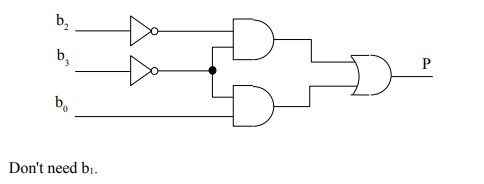

The indexing is kept the same for the oracle. The implementation of quantum AND and OR gates below should give you an idea of larger AND and OR gates. If you still can't figure out the logic of the 2-bit input gates then a detailed explanation for creating these gates exists in the solved notebook of the Qiskit lab 1 assignment stored in this folder.

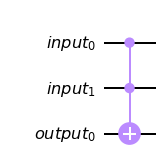

In [72]:
#Quantum AND gate where the bottom most qubit is the output
InputRegsiter = QuantumRegister(2, 'input')
OutputRegister = QuantumRegister(1, 'output')
AndCircuit = QuantumCircuit(InputRegsiter, OutputRegister)

AndCircuit.mct([0, 1], 2)

AndCircuit.draw()

Next is the quantum OR gate. The input for the 2 input register represents the OR gate input and the second qubit's output represents the output for the OR gate.

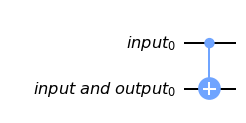

In [73]:
#Quantum OR gate 
InputRegsiter = QuantumRegister(1, 'input')
OutputRegister = QuantumRegister(1, 'input and output')
OrCircuit = QuantumCircuit(InputRegsiter, OutputRegister)

OrCircuit.cx(0, 1)

OrCircuit.draw()

The larger AND gates and OR gates implemented in the oracle are based on these circuits. Based on these two gates it is possible to construct the isPrime part of the Grover search. The next step is applying the CNOT gate to transfer the data to ancilla qubit after which the oracle is completed by uncomputing the isPrime Circuit. Uncomputing is nothing but applying a gate which is the inverse of the gate representing the isPrime circuit. This inversion can be done using Qiskit functions but as only mcts and cnots were used we can use a simpler method. The unitary matrices corresponding to the mct and cnot gates are permuatation matrices, that too the elementary ones, therefore they and their corresponding gates are their own inverses. Knowing this all we need to do in order to invert the isPrime part of the circuit is apply the gates of the isPrime circuit in reverse order.
 

In [5]:
q = QuantumCircuit(1)
q.x(0)
X_gate = q.to_gate()
Zero_control_gate = X_gate.control(4, ctrl_state = 0)
One_control_gate = X_gate.control(4, ctrl_state = 1)

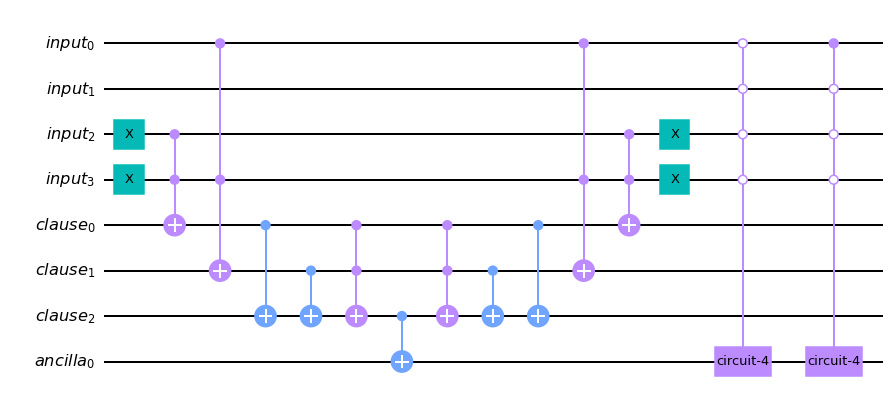

In [74]:
InputRegister = QuantumRegister(4, 'input')
ClauseRegister = QuantumRegister(3, 'clause')
AncillaRegister = QuantumRegister(1, 'ancilla')

four_bit_prime_detector = QuantumCircuit(InputRegister, ClauseRegister, AncillaRegister)

#check isPrime, classical circuit converted to quantum circuit
four_bit_prime_detector.x(3)
four_bit_prime_detector.x(2)
four_bit_prime_detector.ccx(2,3,4)
four_bit_prime_detector.ccx(0,3,5)
four_bit_prime_detector.cx(4,6)
four_bit_prime_detector.cx(5,6)

#ancilla transfer
four_bit_prime_detector.ccx(4,5,6)

#uncomputing the isPrime
four_bit_prime_detector.cx(6,7)
four_bit_prime_detector.ccx(4,5,6)
four_bit_prime_detector.cx(5,6)
four_bit_prime_detector.cx(4,6)
four_bit_prime_detector.ccx(0,3,5)
four_bit_prime_detector.ccx(2,3,4)
four_bit_prime_detector.x(3)
four_bit_prime_detector.x(2)

#Correction in order to ensure 1 and 0 are considered as non primes.
four_bit_prime_detector.append(Zero_control_gate, [0, 1, 2, 3, 7])
four_bit_prime_detector.append(One_control_gate, [0, 1, 2, 3, 7])

sv = Statevector.from_label('00000000').evolve(four_bit_prime_detector)
four_bit_prime_oracle = four_bit_prime_detector.to_gate()

four_bit_prime_detector.draw()

The second gate required for completing the Grover search circuit is amplitude amplification gate or the diffusion operator. The circuit scheme used here is one found across the literature though there are minute differences at times.

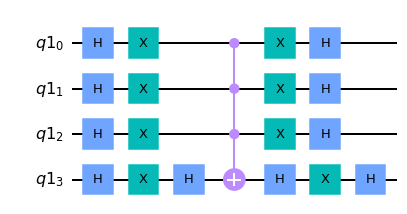

In [7]:
search_qubits =4 #search qubits
def diffusor(n):
    qr = QuantumRegister(n)
    q = QuantumCircuit(qr)
    for i in range(n):
        q.h(i)
        q.x(i)
    # q.barrier()
    q.h(n-1)
    q.mct(qr[:-1], qr[n-1])
    q.h(n-1)
    # q.barrier()
    for i in range(n):
        q.x(i)
        q.h(i)
    return q
diffusion_4 = diffusor(search_qubits).to_gate()
diffusion_4.name = '4 bit diffusion'
qr = QuantumRegister(search_qubits)
q = QuantumCircuit(qr)
q.append(diffusion_4,qr[:])
q.decompose().draw('mpl')

In [8]:
U = Operator(q)
print("4 bit diffusion operator") #matrix representation of the 8 qubit representation
display(array_to_latex(U.data))

4 bit diffusion operator


<IPython.core.display.Latex object>

Grover search's sole advantge against classical search algorithm with time complexity $O(N)$ is it gives a qudratic speedup $O(\sqrt{N})$ in the case of one solution. In precise terms both oracle and diffusion operator need to be applied $\lfloor{\frac{\pi\sqrt{N}}{4}}\rceil$ times. The derivation for this is fairly simple and is shown in the Qiskit tutorial.

In case of $M$ solutions, the required number of iterations becomes $\lfloor{\frac{\pi\sqrt{N/M}}{4}}\rceil$. But there is a problem...
The value of $M$, the number of solutions, is not known for this particular problem. In order to find these solutions we need to use the the __[Quantum Counting algorithm](https://qiskit.org/textbook/ch-algorithms/quantum-counting.html)__. The theory and derivation of the circuit scheme exists on the Qiskit tutorial website. 

In order to use Quantum Counting to find the number of solution we need to simply convert for circuit the Grover search consisting of 2 gates into one gate representing a Grover operator and subsequently create it's single qubit controlled gate.

In [9]:
def Grover_Gate(n, t, oracle, diffusor): #Create Grover gate
    qc = QuantumCircuit(n)
    qc.append(oracle, range(n))
    qc.append(diffusor, range(t))
    return qc
bit_len = 4 #the number of counting bits,

grit = Grover_Gate(bit_len+bit_len, bit_len, four_bit_prime_oracle, diffusor(bit_len).to_gate()).to_gate()
cgrit = grit.control()
cgrit.label = "My Grover gate"

We also need an inverse quantum fourier transform gate. The one written below is the exact same one as the one on the Qiskit website :

In [10]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [11]:
qft_dagger = qft(bit_len).to_gate().inverse()
qft_dagger.label = "QFT†"

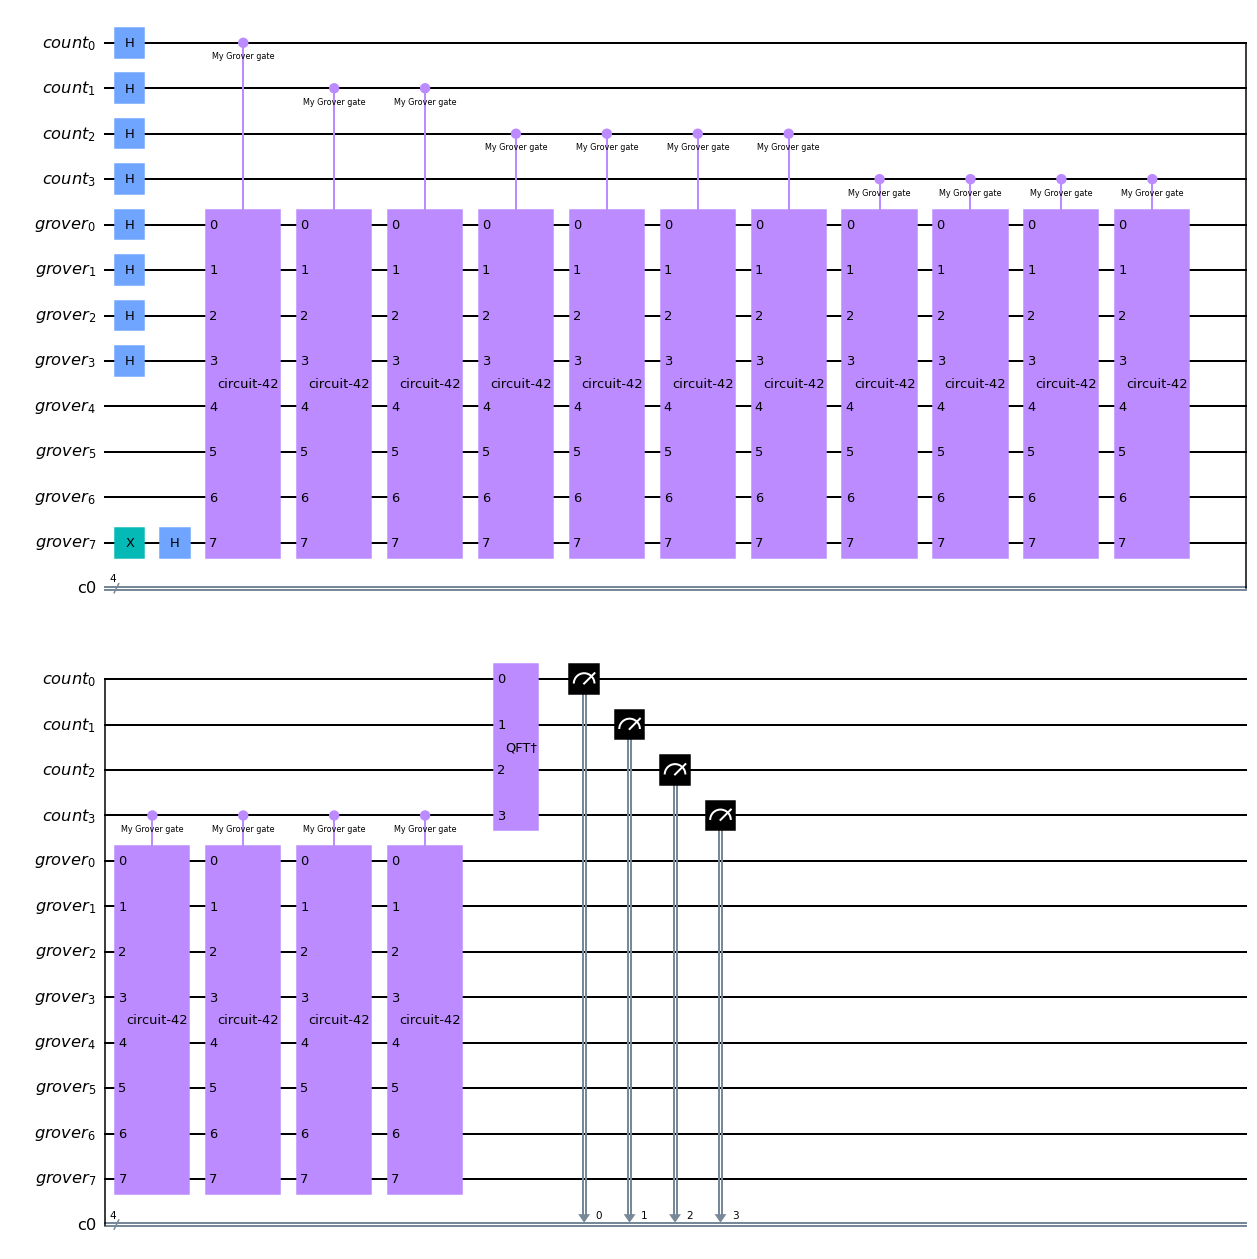

In [12]:
CoutingRegister = QuantumRegister(bit_len, 'count')
Grover_qubits = 8 #searching qubits doing the Grover algorithm part
GroverRegister = QuantumRegister(Grover_qubits, 'grover')
Classical_CountingRegister = ClassicalRegister(bit_len)
qc = QuantumCircuit(CoutingRegister, GroverRegister, Classical_CountingRegister)

for i in range(bit_len+bit_len):
    qc.h(i)
qc.x(-1)
qc.h(-1)
iterations = 1
for qubit in range(bit_len):
    for i in range(iterations):
        qc.append(cgrit, [qubit]+[*range(bit_len, bit_len+Grover_qubits)])
    iterations *= 2
    
qc.append(qft_dagger, range(bit_len))
qc.measure(range(bit_len),  range(bit_len))

qc.draw('mpl')

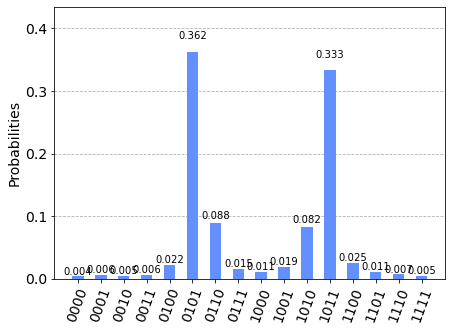

In [13]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=4096)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [14]:
measured_str = max(counts, key=counts.get)
measured_int = int(measured_str,2)
print( (measured_int+1)%(12) )
increment = counts.get(format((measured_int+1)%(2**bit_len), '04b'), -1)/counts.get(format(measured_int, '04b'), -1) 
decrement = -counts.get(format((measured_int-1)%(2**bit_len), '04b'), -1)/counts.get(format(measured_int, '04b'), -1)

measured_float = measured_int + increment + decrement 
print("Register Output = %i" % measured_float)
theta = (measured_float/(2**bit_len))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**bit_len
M = N * (math.sin(theta/2)**2)
approx_solutions = round(N-M)
print("No. of Solutions = %.1f" %  approx_solutions )

6
Register Output = 5
Theta = 2.03579
No. of Solutions = 4.0


We now have an approximate number of solutions. The real solution may differ by +1 or -1 but the approximation is precise enough for us to determine the number of times the Grover gate must be applied in order to obtain a solution.
The circuit below is the full Grover search circuit for the problem :

Required number of Grover iterations =  1


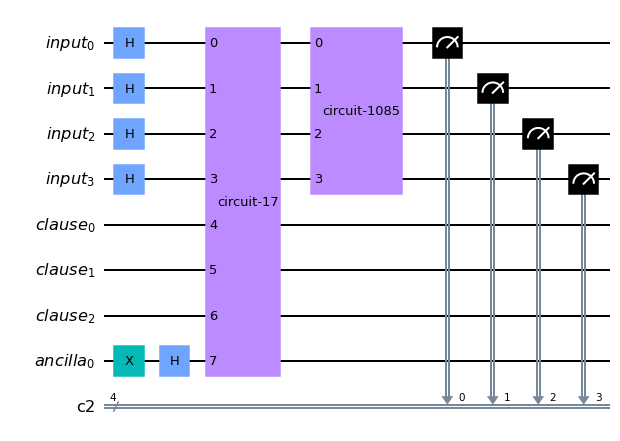

In [16]:
answer_qubits = 4
clasue_and_ancilla = 4

qr = QuantumRegister(answer_qubits+clasue_and_ancilla)
cr = ClassicalRegister(clasue_and_ancilla)
four_isPrime_Grover_circuit = QuantumCircuit(InputRegister, ClauseRegister, AncillaRegister, cr)

for i in range(answer_qubits):
    four_isPrime_Grover_circuit.h(i)

# initialize ancilla in hadamard state |->
four_isPrime_Grover_circuit.x(-1)
four_isPrime_Grover_circuit.h(-1)

#N = 2**n and M is the number of solutions
#required number of iterations is (pie/4)(sqrt(N/M))

m = approx_solutions
iterations = int( (math.pi/4) * math.sqrt((2**answer_qubits/m)) )

for i in range(iterations):
    four_isPrime_Grover_circuit.append(four_bit_prime_oracle, range(answer_qubits+clasue_and_ancilla) )
    four_isPrime_Grover_circuit.append(diffusor(answer_qubits).to_gate(), range(answer_qubits))


four_isPrime_Grover_circuit.measure(range(answer_qubits), range(answer_qubits))

print("Required number of Grover iterations = ", iterations)
four_isPrime_Grover_circuit.draw()

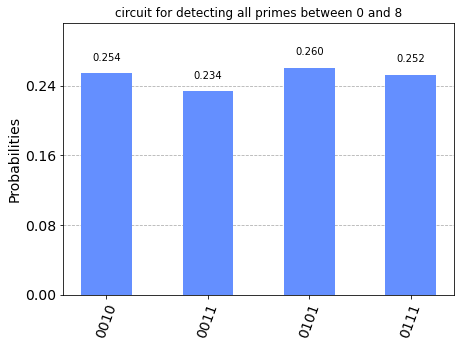

In [17]:
backend = Aer.get_backend('qasm_simulator')
shots = 4096 #max number of shots possible
job = execute(four_isPrime_Grover_circuit, backend, shots = shots)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title = 'circuit for detecting all primes between 0 and 8')

In [18]:
sort_orders = sorted(counts.items(), key=lambda x:x[1], reverse = True)

m = 1
total_percentage = 0 
for i in sort_orders:
    if(i[1] > shots/45) and int(i[0], 2) >= 2 :
        total_percentage += (i[1]/shots)*100 
        print("solution number ", m)
        print("prime = ", int(i[0], 2))
        print("Probability : ", i[1], "/", shots, " or ", (i[1]/shots)*100, " %")
        print()
        m += 1

print("Total number of solutions : ", m-1)
print("Probability of getting a right answer : ", total_percentage, "%")

solution number  1
prime =  5
Probability :  1065 / 4096  or  26.0009765625  %

solution number  2
prime =  2
Probability :  1040 / 4096  or  25.390625  %

solution number  3
prime =  7
Probability :  1033 / 4096  or  25.2197265625  %

solution number  4
prime =  3
Probability :  958 / 4096  or  23.388671875  %

Total number of solutions :  4
Probability of getting a right answer :  100.0 %


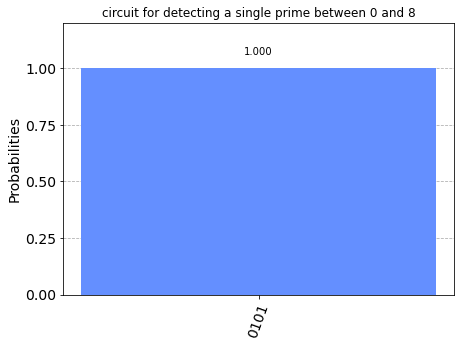

In [19]:
backend = Aer.get_backend('qasm_simulator')
shots = 1
job = execute(four_isPrime_Grover_circuit, backend, shots = shots)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title = 'circuit for detecting a single prime between 0 and 8')

In [25]:
i = list(counts)

print("solution ")
print("prime = ", int(i[0], 2))
print()

solution 
prime =  5



<h2>5 bit prime detector for detecting primes between 0 and 32<h2>

Now we can move onto to the circuit for detecting prime numbers between 0 and 32. The source for this circuit is [this](https://www.youtube.com/watch?v=7fICbHAt8kU) YouTube video which has a link to the parent website. The circuit scheme is as follows : 

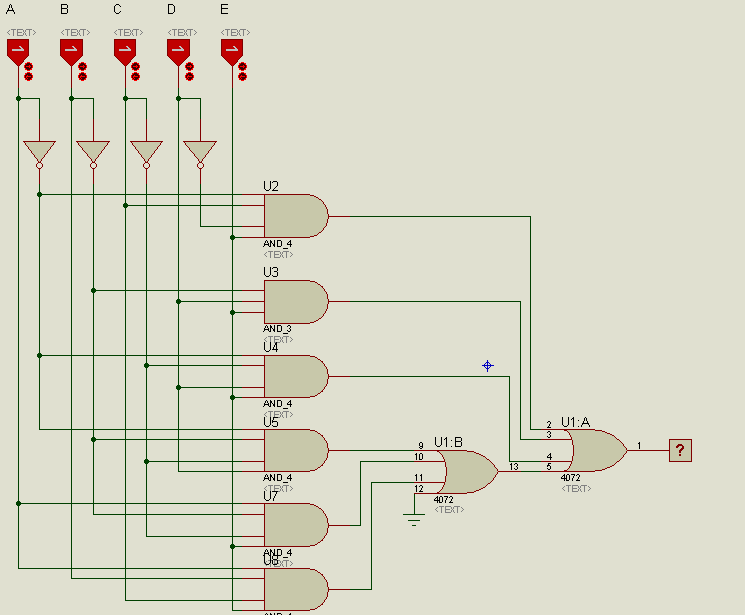

In [26]:
q = QuantumCircuit(1)
q.x(0)
X_gate = q.to_gate()
Five_control_gate = X_gate.control(5, ctrl_state = 5)
Seven_control_gate = X_gate.control(5, ctrl_state = 9)

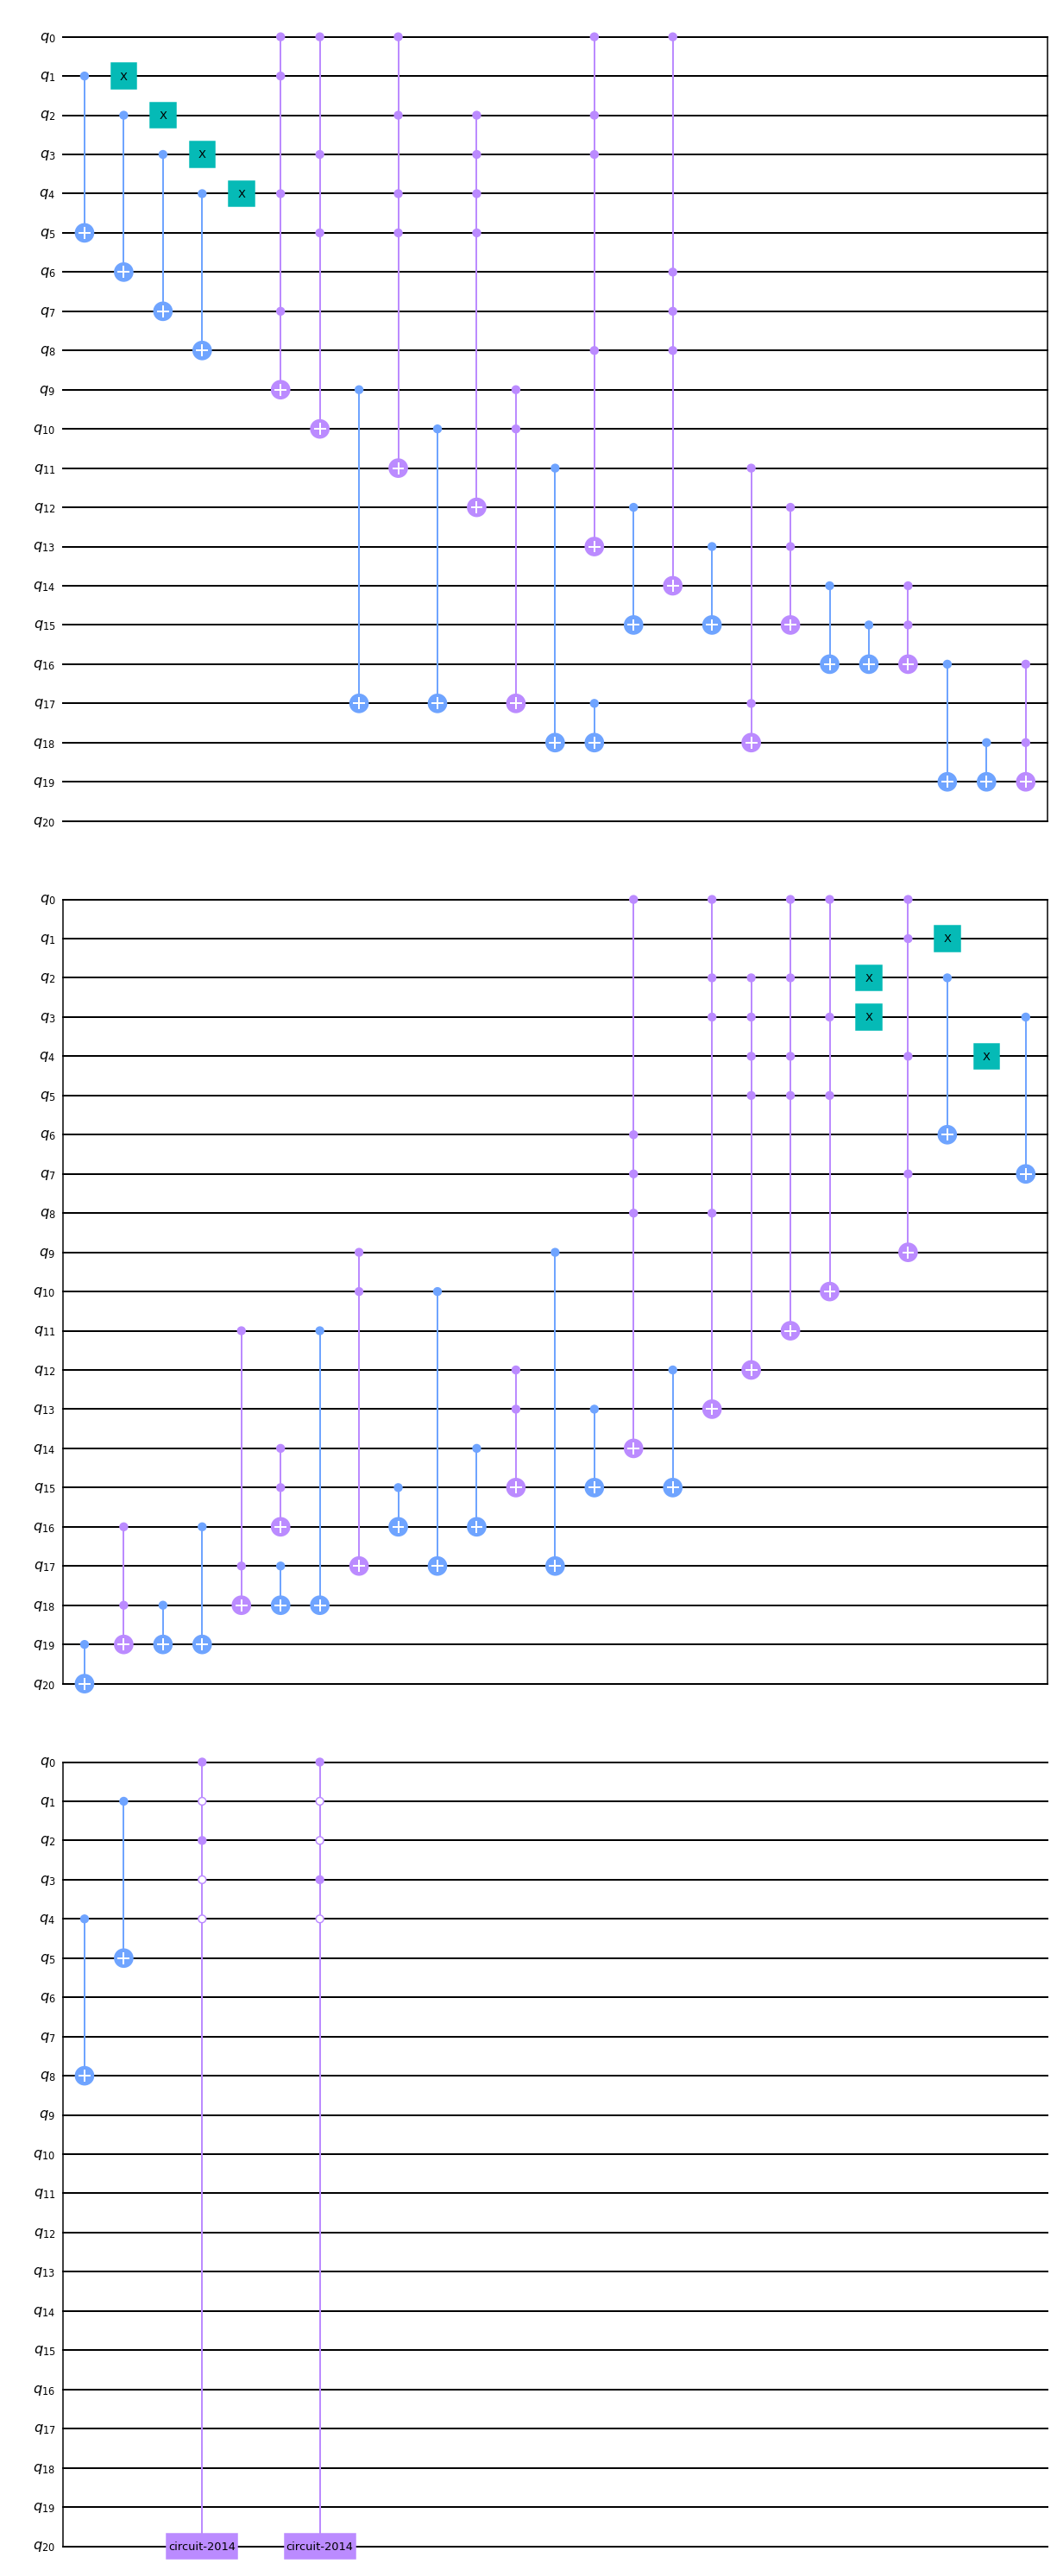

In [27]:
q = QuantumCircuit(21)

#------------------------------------------isPrime part of the oracle------------------------------------------------------
# q.barrier()
for i in range(1,5,1):
    q.cx(i,i+4)
# q.barrier()
for i in range(1,5,1):
    q.x(i)


q.mct([0, 1, 4, 7], 9)
q.mct([0, 3, 5], 10)
q.mct([0, 2, 4, 5], 11)
q.mct([2, 3, 4, 5], 12)
q.mct([0, 2, 3, 8], 13)
q.mct([0, 6, 7, 8], 14)

# q.barrier()
q.cx(12, 15)
q.cx(13, 15)
q.mct([12, 13], 15)
# q.barrier()
q.cx(14, 16)
q.cx(15, 16)
q.mct([14, 15], 16)

# q.barrier()

q.cx(9, 17)
q.cx(10, 17)
q.mct([9, 10], 17)
# q.barrier()
q.cx(11, 18)
q.cx(17, 18)
q.mct([11, 17], 18)
# q.barrier()
q.cx(16, 19)
q.cx(18, 19)
q.mct([16, 18], 19)
# q.barrier()

#------------------------------------------ancilla qubit to which data is transferred---------------------------------------
q.cx(19, 20)

#------------------------------------------------uncomputing the isPrime circuit---------------------------------------
# # q.barrier()
q.mct([16, 18], 19)
q.cx(18, 19)
q.cx(16, 19)
# q.barrier()
q.mct([11, 17], 18)
q.cx(17, 18)
q.cx(11, 18)
# q.barrier()
q.mct([9, 10], 17)
q.cx(10, 17)
q.cx(9, 17)

# # q.barrier()

q.mct([14, 15], 16)
q.cx(15, 16)
q.cx(14, 16)
# q.barrier()
q.mct([12, 13], 15)
q.cx(13, 15)
q.cx(12, 15)
# q.barrier()

q.mct([0, 6, 7, 8], 14)
q.mct([0, 2, 3, 8], 13)
q.mct([2, 3, 4, 5], 12)
q.mct([0, 2, 4, 5], 11)
q.mct([0, 3, 5], 10)
q.mct([0, 1, 4, 7], 9)

# # q.barrier()
for i in range(1,5,1):
    q.x(i)
# # q.barrier()
for i in range(4,0,-1):
    q.cx(i,i+4)

#correcting the mistake of 5 as non prime and 9 as prime    
q.append(Five_control_gate, [0, 1, 2, 3, 4, 20])
q.append(Seven_control_gate, [0, 1, 2, 3, 4, 20])

five_bit_prime_detector = q.to_gate()

q.draw()#scale=0.5

In [28]:
counting_qubits = 4 #counting qubits doing Quantum counting algo part
n = 21 #searching qubits doing the Grover algorithm part, the isze is 21 as that is the size of the oracle which is greater than that of the diffusor
GroverQubits = 5 #Grover search qubits 

In [30]:
diffusion_5 = diffusor(GroverQubits).to_gate()
Grover = Grover_Gate(n, GroverQubits, five_bit_prime_detector, diffusion_5).to_gate()
ctr_Grover = Grover.control()
qft_dagger = qft(counting_qubits).to_gate().inverse()
qft_dagger.label = "QFT†"

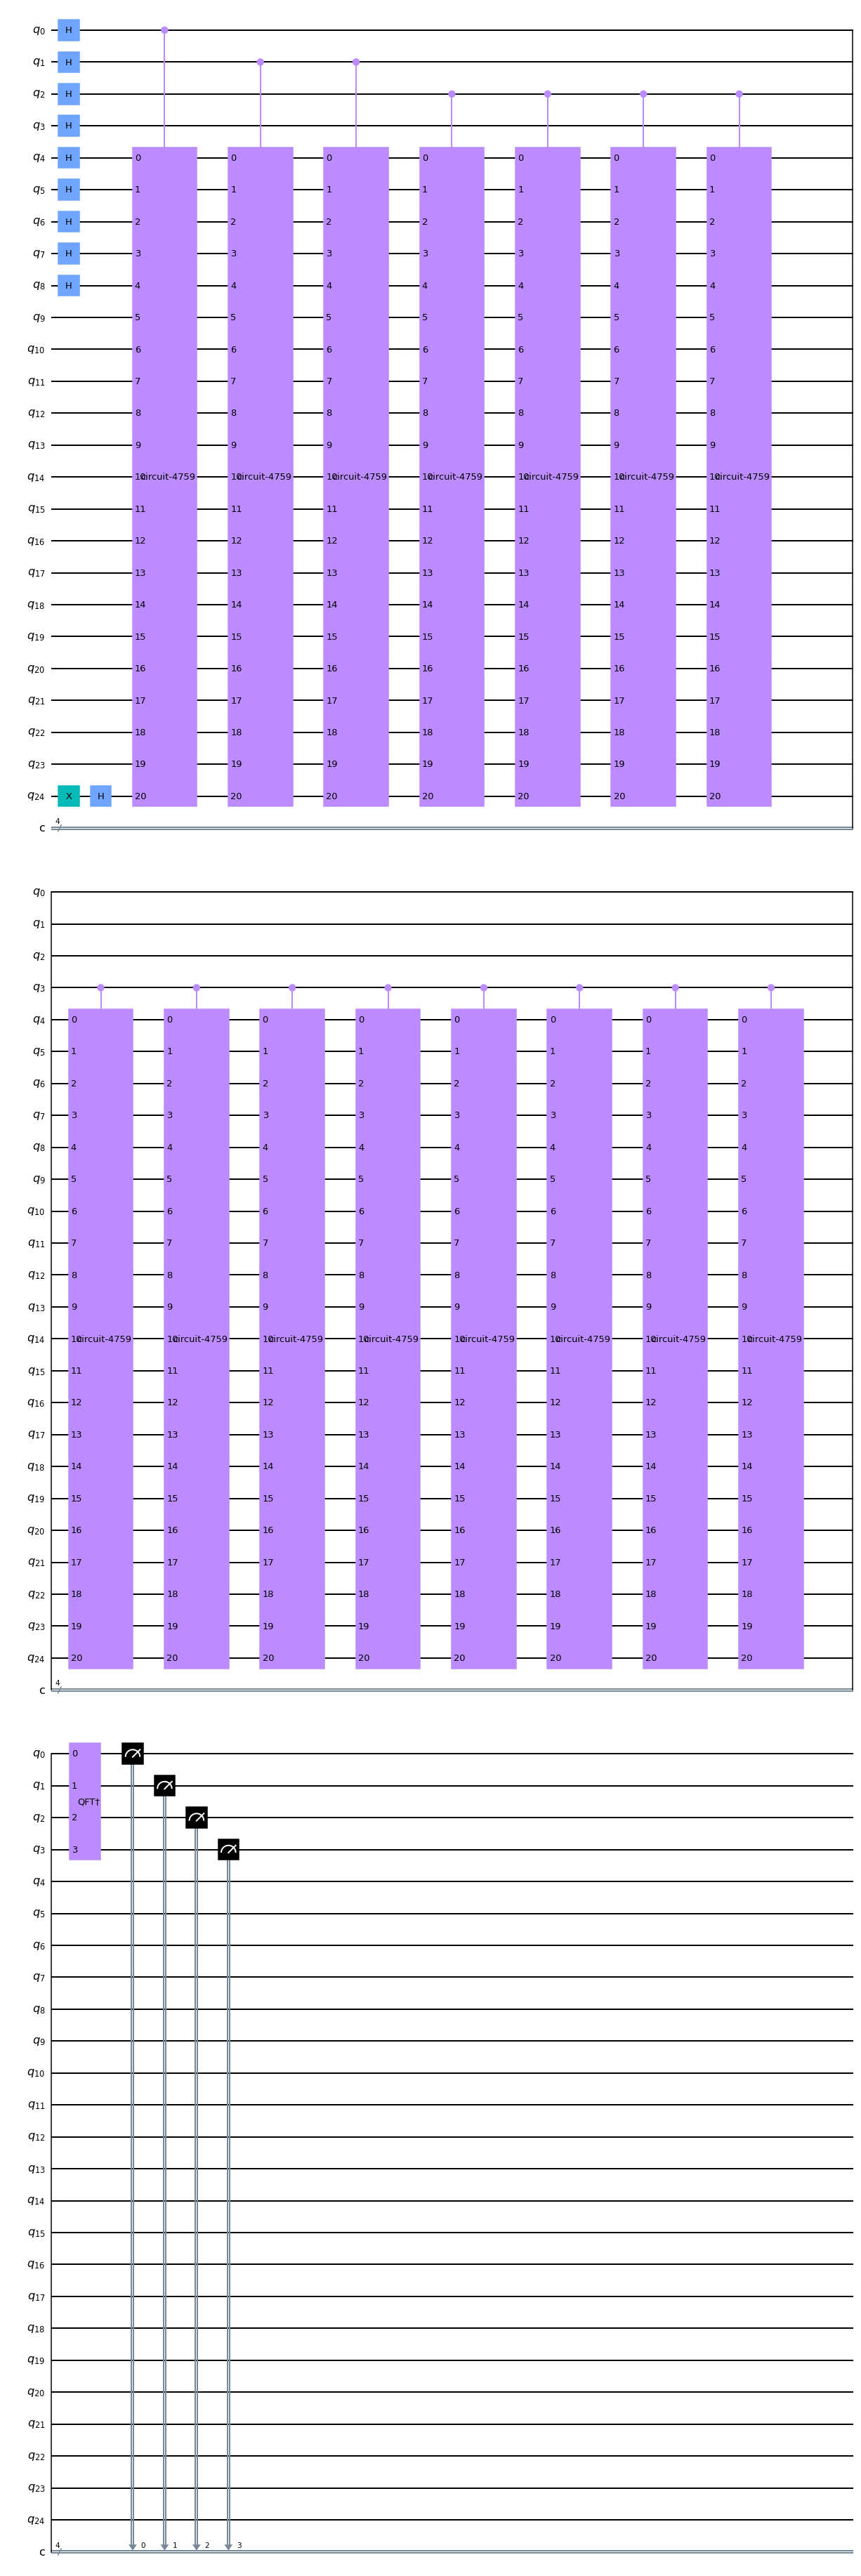

In [32]:
#search_bits for Grover 
m = GroverQubits

qc = QuantumCircuit(n+counting_qubits, counting_qubits)

for i in range(counting_qubits+m):
    qc.h(i)
qc.x(-1)
qc.h(-1)
iterations = 1
for qubit in range(counting_qubits):
    for i in range(iterations):
        qc.append(ctr_Grover, [qubit]+[*range(counting_qubits, n+counting_qubits)])
    iterations *= 2
    
qc.append(qft_dagger, range(counting_qubits))
qc.measure(range(counting_qubits),  range(counting_qubits))

qc.draw()

In [33]:
print("Quantum counting for 5 bit prime depth: ", qc.depth())

Quantum counting for 5 bit prime depth:  19


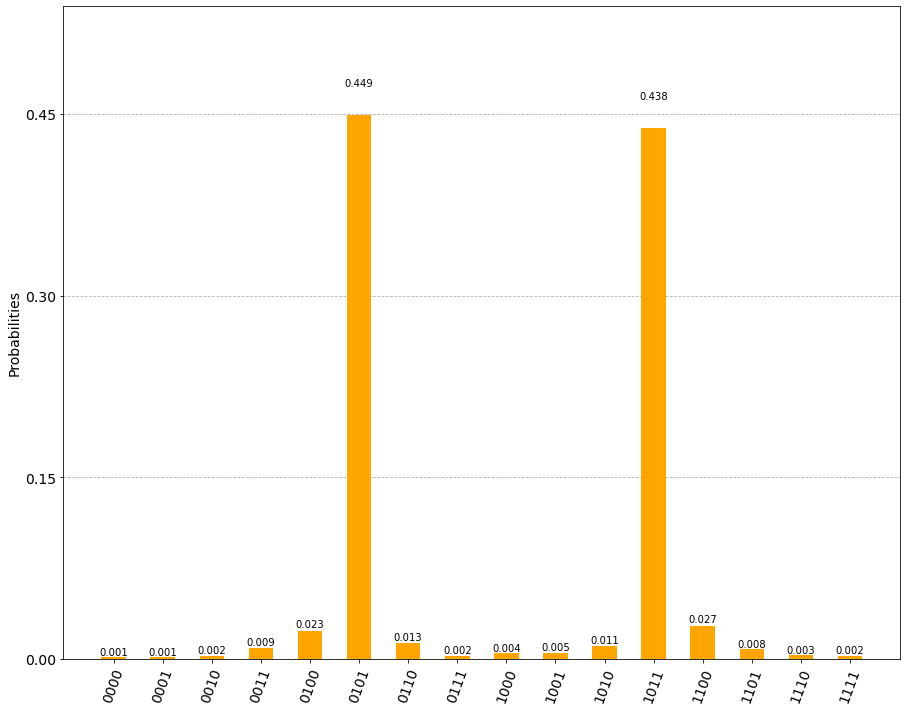

In [50]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=2048)
result = job.result()
counts = result.get_counts()

plot_histogram(counts, figsize=(15, 12), color='orange')

In [57]:
measured_str = max(counts, key=counts.get)
measured_int = int(measured_str, 2)
increment = counts.get(format((measured_int+1)%2**counting_qubits, '04b'), -1)/counts.get(format(measured_int, '04b'), -1) 
decrement = -counts.get(format((measured_int-1)%2**counting_qubits, '04b'), -1)/counts.get(format(measured_int, '04b'), -1)
measured_float = measured_int + increment + decrement 

theta = (measured_int/(2**counting_qubits))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**counting_qubits
M = N * (math.sin(theta/2)*2)
approx_solutions = round(abs(N-M)) 
print("Number of solutions = %.1f" % (approx_solutions) )

Theta = 1.96350
Number of solutions = 11.0


We now have the approximate number of solutions. The real number of solutions may differ by +1 or -1 but the approximation is precise enough for us to determine the number of times the Grover gate must be applied in order to obtain a solution.
The circuit below is the full Grover search circuit for the problem :

Required number of Grover iterations =  1


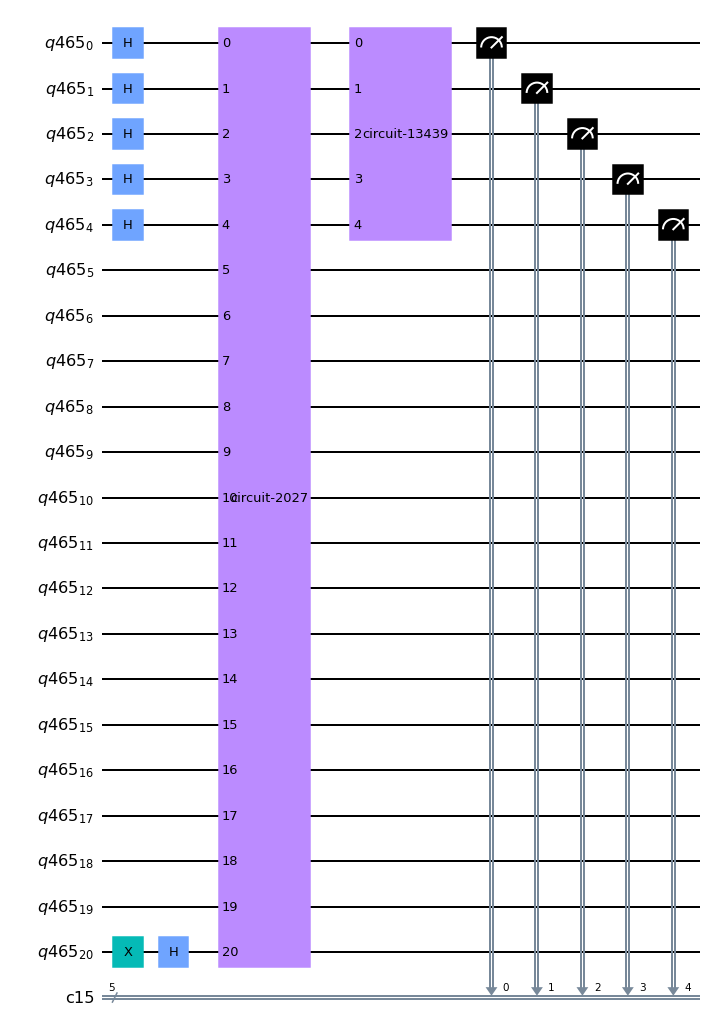

In [75]:
search_qubits = 5 #the qubits containing the output of the search
circuitSize = 21
qr = QuantumRegister(circuitSize)
cr = ClassicalRegister(search_qubits)
GroverCircuit = QuantumCircuit(qr, cr)

GroverCircuit.x(-1)
for i in range(search_qubits):
    GroverCircuit.h(i)
GroverCircuit.h(-1)

#N = 2**n and M is the number of solutions
#required number of iterations is (pie/4)(sqrt(N/M))

m = approx_solutions
iterations = round( (math.pi/4) * math.sqrt((2**search_qubits/m)) ) 

diffusion_5 = diffusor(search_qubits).to_gate()

for i in range(iterations):
    GroverCircuit.append(five_bit_prime_detector, qr[:])
    GroverCircuit.append(diffusion_5,[0,1,2,3,4])

for i in range(search_qubits):
    GroverCircuit.measure(i,i)

print("Required number of Grover iterations = ", iterations)
GroverCircuit.draw()#, plot_barriers=False, reverse_bits=True

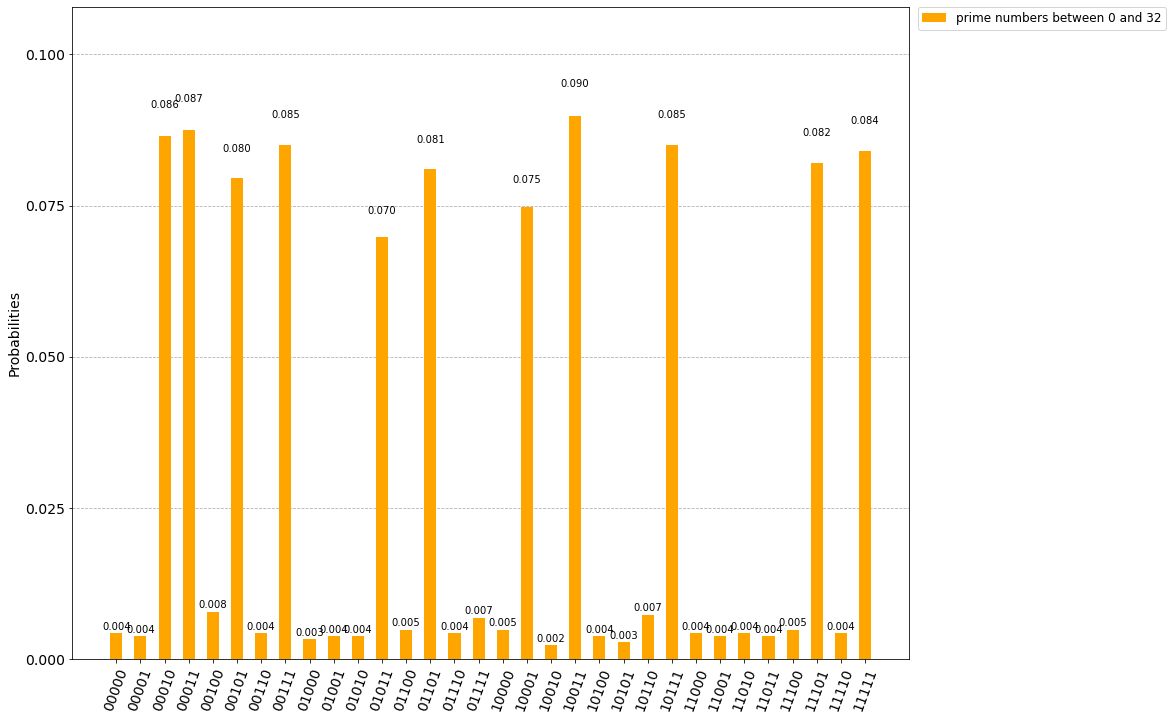

In [76]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048
job = execute(GroverCircuit, QasmSimulator(), shots=2048)
result = job.result()
counts = result.get_counts()
legend = ['prime numbers between 0 and 32']
plot_histogram(counts, legend = legend, figsize=(15, 12), color='orange')

In [77]:
sort_orders = sorted(counts.items(), key=lambda x:x[1], reverse = True)

m = 1
total_percentage = 0 
for i in sort_orders:
    if(i[1] > shots/45) and int(i[0], 2) >= 2 :
        total_percentage += (i[1]/shots)*100 
        print("solution number ", m)
        print("prime = ", int(i[0], 2))
        print("Probability : ", i[1], "/", shots, " or ", (i[1]/shots)*100, " %")
        print()
        m += 1

print("Total number of solutions : ", m-1)
print("Probability of getting a right answer : ", total_percentage, "%")

solution number  1
prime =  19
Probability :  184 / 2048  or  8.984375  %

solution number  2
prime =  3
Probability :  179 / 2048  or  8.740234375  %

solution number  3
prime =  2
Probability :  177 / 2048  or  8.642578125  %

solution number  4
prime =  7
Probability :  174 / 2048  or  8.49609375  %

solution number  5
prime =  23
Probability :  174 / 2048  or  8.49609375  %

solution number  6
prime =  31
Probability :  172 / 2048  or  8.3984375  %

solution number  7
prime =  29
Probability :  168 / 2048  or  8.203125  %

solution number  8
prime =  13
Probability :  166 / 2048  or  8.10546875  %

solution number  9
prime =  5
Probability :  163 / 2048  or  7.958984375  %

solution number  10
prime =  17
Probability :  153 / 2048  or  7.470703125  %

solution number  11
prime =  11
Probability :  143 / 2048  or  6.982421875  %

Total number of solutions :  11
Probability of getting a right answer :  90.478515625 %


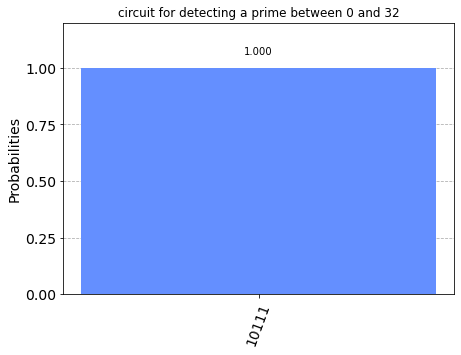

In [78]:
backend = Aer.get_backend('qasm_simulator')
shots = 1
job = execute(GroverCircuit, backend, shots = shots)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, title = 'circuit for detecting a prime between 0 and 32')

In [68]:
i = list(counts)

print("solution ")
print("prime = ", int(i[0], 2))
print()

solution 
prime =  3

